In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import numpy as np
import random
import xgboost as xgb
import pandas as pd
import os
import pickle

random.seed(42)
np.random.seed(42)


In [53]:
from folktables import ACSDataSource, ACSIncome

data_source = []
features_years, label_years, group_years = [], [], []
for year in ['2014', '2018']:
    data_source = ACSDataSource(survey_year=year, horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=["CA"], download=True)
    features_i, label_i, _ = ACSIncome.df_to_numpy(acs_data)
    mask = np.arange(0, len(label_i))
    random.shuffle(mask)
    features_years.append(features_i[mask])
    label_years.append(label_i[mask])

features = np.concatenate(features_years)
label = np.concatenate(label_years)

In [54]:
p = 1
train_size = int(p*features_years[0].shape[0])
features_train, labels_train = features[:train_size], label[:train_size]
features_test, labels_test = features[train_size:], label[train_size:]

features_train.shape, features_test.shape

((183941, 10), (195665, 10))

In [55]:
df_train_unproc = pd.DataFrame(features_train, columns=ACSIncome.features)
df_test_unproc = pd.DataFrame(features_test, columns=ACSIncome.features)

In [56]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num = ['AGEP',  'WKHP']
categ = [ 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX', 'RAC1P']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categ)])

In [57]:
df_train_prep = preprocessor.fit_transform(df_train_unproc)

In [58]:

xgb_model = xgb.XGBClassifier()
xgb_model.fit(df_train_prep, labels_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [59]:
df_test_prep = preprocessor.transform(df_test_unproc)

In [60]:
ckpt_dir = 'folktables'
os.makedirs(ckpt_dir, exist_ok=True)

model_filename = os.path.join(ckpt_dir, f"xgb_folktables.pkl")
with open(model_filename, "wb") as f:
        pickle.dump(xgb_model, f)


ds_filename = os.path.join(ckpt_dir, f"folktables_data.pkl")

with open(ds_filename, "wb") as f:
        pickle.dump({
                "train": df_train_unproc,
                "test_chunks": df_test_unproc,
                "numerical": num,
                "categorical": categ,
                "transform": preprocessor
        }, f)

In [61]:
xgb_model.score(df_test_prep, labels_test)

0.8075128408248793

In [62]:
labels_test_pred= xgb_model.predict(df_test_prep)

In [63]:
accs = []
from sklearn.metrics import accuracy_score

batch_size = 1000

num_iterations = df_test_unproc.shape[0] // batch_size

df_tests_unsup = []

balance = []
for i in range(num_iterations + 1):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    
    labels_test_i = labels_test[start_idx:end_idx]
    labels_test_pred_i = xgb_model.predict(df_test_prep[start_idx:end_idx])
    accs.append( accuracy_score(labels_test_i, labels_test_pred_i))
    balance.append(np.mean(labels_test_pred_i == 1))

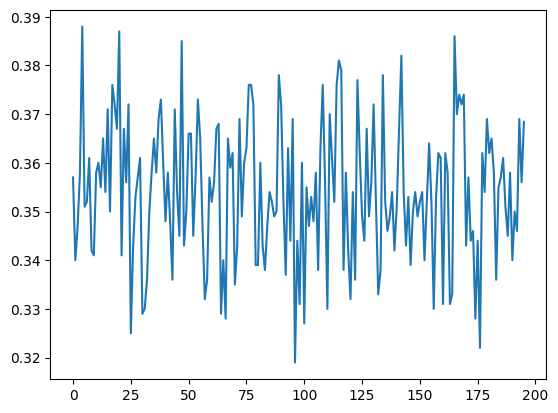

In [64]:
import matplotlib.pyplot as plt
plt.plot(balance)

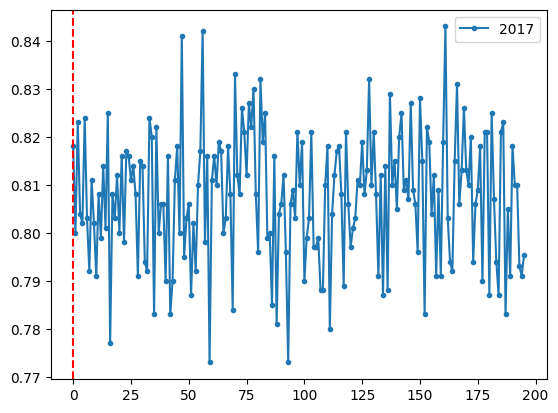

In [65]:
import matplotlib.pyplot as plt
plt.plot(accs, '.-', label='2017')
plt.axvline((features_years[0].shape[0]-train_size)/5000, color='r', linestyle='--')
plt.legend()

# Use drift explorer

In [66]:
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

bool_preprocessor = ColumnTransformer(
transformers=[
    # numerical features : bins + 1-hot
    ('num', Pipeline([
        ('bins', KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='uniform')),
        ]), num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categ)], 
    sparse_threshold=0)

In [67]:

import sys
sys.path.append("..")
from divexp import *
from tqdm import tqdm

minsup = 0.05


df_train_unsup = pd.DataFrame(data=bool_preprocessor.fit_transform(df_train_unproc), columns=bool_preprocessor.get_feature_names_out()).astype(bool)

In [68]:

matches = compute_matches(df_train_unsup, minsup=minsup, n_proc=36)

matches_ts_list = []
df_tests = []
from tqdm import tqdm 

batch_size = 1000 
num_iterations = df_test_unproc.shape[0] // batch_size

df_tests_unsup = []
for i in range(num_iterations + 1):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    df_test_i = df_test_unproc[start_idx:end_idx]
    df_test_unsup = pd.DataFrame(bool_preprocessor.transform(df_test_i), columns=bool_preprocessor.get_feature_names_out()).astype(bool)
    matches_ts = compute_matches(df_test_unsup, fi=matches.fi)
    matches_ts_list.append(matches_ts)
    df_tests_unsup.append(df_test_unsup)

In [69]:
y_trues = []
y_preds = []

divs = []

for i in range(num_iterations + 1):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    df_test_prep_i = df_test_prep[start_idx:end_idx]
    y_true_i = labels_test[start_idx:end_idx]
    y_pred_i = xgb_model.predict(df_test_prep_i)

    matches_ts_i = matches_ts_list[i]

    from divexp import Matches
    matches = Matches(matches=matches_ts_i.matches.astype(int), fi=matches_ts_i.fi)


    divs.append(div_explorer(matches, np.array(y_true_i), np.array(y_pred_i), ['accuracy']))

In [70]:
from detect import detect_singlebatch

n_wind = 2
start_win_drift = 4
delta, t_stat = detect_singlebatch(divs, 'accuracy', (0, n_wind), (start_win_drift, n_wind))

In [71]:
df_res = pd.DataFrame(np.vstack([matches.fi.itemsets.values, t_stat.values, delta.values]).T, columns=['group_ids', 't_stat', 'delta'])
df_res['group'] = df_res.group_ids.apply(lambda x: [bool_preprocessor.get_feature_names_out()[int(i)] for i in x])
convert = bool_preprocessor.get_feature_names_out().tolist().index
df_res

,group_ids,t_stat,delta,group
0,(10),1.345646,-0.019987,[cat__COW_1.0]
1,(757),0.594259,0.0094,[cat__RAC1P_1.0]
2,(42),0.419184,0.007545,[cat__MAR_1.0]
3,(755),0.170064,-0.00299,[cat__SEX_1.0]
4,(528),0.209256,-0.003676,[cat__POBP_6.0]
...,...,...,...,...
707,"(3, 757)",0.336934,0.017864,"[num__AGEP_3.0, cat__RAC1P_1.0]"
708,"(42, 39)",1.407594,0.064464,"[cat__MAR_1.0, cat__SCHL_22.0]"
709,"(737, 39)",0.663373,0.033482,"[cat__RELP_0.0, cat__SCHL_22.0]"
710,"(6, 39)",0.901329,0.049875,"[num__WKHP_1.0, cat__SCHL_22.0]"


In [72]:
for d in divs:
    d['accuracy'] = (d['tp'] + d['tn'])/ (d['fp'] + d['fn'] + d['tp'] + d['tn'])

In [73]:
idxs = list(df_res.sort_values(['delta'], ascending=False, key=abs).index)

In [74]:
df_res.sort_values(['delta'], ascending=False, key=abs)

,group_ids,t_stat,delta,group
619,"(665, 42, 755)",2.998136,-0.192339,"[cat__POBP_303.0, cat__MAR_1.0, cat__SEX_1.0]"
351,"(528, 737, 2)",3.229881,-0.1704,"[cat__POBP_6.0, cat__RELP_0.0, num__AGEP_2.0]"
357,"(528, 737, 2, 757)",2.925926,-0.16369,"[cat__POBP_6.0, cat__RELP_0.0, num__AGEP_2.0, ..."
95,"(737, 6, 10, 528, 757)",2.979358,-0.162112,"[cat__RELP_0.0, num__WKHP_1.0, cat__COW_1.0, c..."
355,"(528, 2, 756)",2.410407,-0.140357,"[cat__POBP_6.0, num__AGEP_2.0, cat__SEX_2.0]"
...,...,...,...,...
277,"(737, 42)",0.004476,0.00011,"[cat__RELP_0.0, cat__MAR_1.0]"
681,"(10, 38, 6)",0.002441,0.000106,"[cat__COW_1.0, cat__SCHL_21.0, num__WKHP_1.0]"
23,(38),0.00347,0.000093,[cat__SCHL_21.0]
466,"(0, 528, 757, 6)",0.0,0.0,"[num__AGEP_0.0, cat__POBP_6.0, cat__RAC1P_1.0,..."


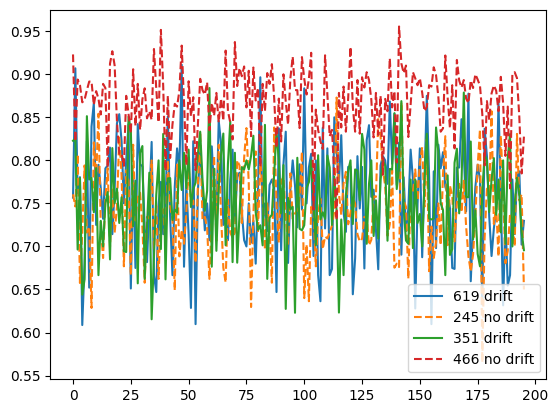

In [75]:
for i in range(2):

    idx1 = idxs[i]
    acc2 = [d.loc[idx1]['accuracy'] for d in divs]
    plt.plot(acc2, label = f'{idx1} drift')


    idx2 = idxs[-i-1]
    acc2 = [d.loc[idx2]['accuracy'] for d in divs]

    plt.plot(acc2, label = f'{idx2} no drift', linestyle='--')

plt.legend()